In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Plt rcParams font family
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'


# Whitesmoke background
plt.rcParams['axes.facecolor'] = 'whitesmoke'


# Grid style
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True


# Assignment 4 - Modelling the spread of HIV
### *Niels August Davidsen (phx657)*
#### Handin: Oct. 20th. 12am

___

In [67]:
# Project framework - HIV through sexual contact
def dx1_dt(x1, x2, p1, a1, a2, e=None, death="Off", r1=0):
    dx1_dt_simple = a1*x1*(p1 - x1) + a2*x2*(p1 - x1)
    if e is not None and death == "Off":
        return dx1_dt_simple + e*(p1 - x1)
    elif death == "On" and e is None:
        return dx1_dt_simple - r1 * x1
    elif e is not None and death == "On":
        return dx1_dt_simple + e*(p1 - x1) - r1 * x1
    else:
        return dx1_dt_simple

def dx2_dt(x1, x2, y, p2, b1, b2, b3, e=None, death="Off", r2=0):
    dx2_dt_simple = b1*x1*(p2 - x2) + b2*x2*(p2 - x2) + b3*y*(p2 - x2)
    if e is not None and death == "Off":
        return dx2_dt_simple + e*(p2 - x2)
    elif death == "On" and e is None:
        return dx2_dt_simple - r2 * x2
    elif e is not None and death == "On":
        return dx2_dt_simple + e*(p2 - x2) - r2 * x2
    else:
        return dx2_dt_simple

def dy_dt(x2, y, z, q, c1, c2, e=None, death="Off", r3=0):
    dy_dt_simple = c1*x2*(q - y) + c2*z*(q - y)
    if e is not None and death == "Off":
        return dy_dt_simple + e*(q - y)
    elif death == "On" and e is None:
        return dy_dt_simple - r3 * y
    elif e is not None and death == "On":
        return dy_dt_simple + e*(q - y) - r3 * y
    else:
        return dy_dt_simple

def dz_dt(y, z, r, d1, e=None, death="Off", r4=0):
    dz_dt_simple = d1*y*(r - z)
    if e is not None and death == "Off":
        return dz_dt_simple + e*(r - z)
    elif death == "On" and e is None:
        return dz_dt_simple - r4 * z
    elif e is not None and death == "On":
        return dz_dt_simple + e*(r - z) - r4 * z
    else:
        return dz_dt_simple

def hiv_derivs(state, params, e_base=0):
    x1, x2, y, z = state
    p1, p2, q, r, a1, a2, b1, b2, b3, c1, c2, d1, e, death, rs = params

    frac = (x1 + x2 + y + z) / (p1 + p2 + q + r)
    e = e_base * frac

    dx1 = dx1_dt(x1, x2, p1, a1, a2, e, death, rs[0])
    dx2 = dx2_dt(x1, x2, y, p2, b1, b2, b3, e, death, rs[1])
    dy = dy_dt(x2, y, z, q, c1, c2, e, death, rs[2])
    dz = dz_dt(y, z, r, d1, e, death, rs[3])
    return np.array([dx1, dx2, dy, dz])



# Euler and RK4 methods
def euler_step(dt, derivs, state):
    x1, x2, y, z = state
    x1_new = x1 + derivs[0] * dt
    x2_new = x2 + derivs[1] * dt
    y_new = y + derivs[2] * dt
    z_new = z + derivs[3] * dt
    return x1_new, x2_new, y_new, z_new

def rk4_step(dt, derivs, state, params, e_base=0):
    k1 = derivs(state, params, e_base)
    k2 = derivs(state + 0.5 * dt * k1, params, e_base)
    k3 = derivs(state + 0.5 * dt * k2, params, e_base)
    k4 = derivs(state + dt * k3, params, e_base)
    return state + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)



# Simulation functions
def run_euler(init_state, params, time, e_base=0):
    state = init_state
    res_euler = np.zeros((len(time), 4))
    dt = time[1] - time[0]

    for i, t in enumerate(time):
        res_euler[i] = state
        derivs = hiv_derivs(state, params, e_base=e_base)
        state = euler_step(dt, derivs, state)

    return res_euler

def run_rk4(init_state, params, time, e_base=0):
    state = init_state
    res_rk4 = np.zeros((len(time), 4))
    dt = time[1] - time[0]


    for i, t in enumerate(time):
        res_rk4[i] = state
        state = rk4_step(dt, hiv_derivs, state, params, e_base=e_base)

    return res_rk4





## Modelling the spread of HIV through sexual contact

To start with we were given equations (1), (2), (3) and (4). These equations describe the spread of HIV through sexual contact in four different groups:

* $p_1$: Homosexual Males with $x_1$ infected persons
* $p_2$: Bisexual Males with $x_2$ infected persons
* $q$: Heterosexual Females with $y$ infected persons
* $r$: Heterosexual Males with $z$ infected persons

Through the equations it is clear to see, that some groups are coupled to other groups for example bisexual males who are coupled to themselves, heterosexual females and homosexual males.

All equations are scaled with some constants $a_1$, $a_2$, $b_1$ etc. These all controls the rates of infection for a specific group through contact with some group (also themselves).
The constants are mostly kept the same as specified in the assignment, but it is discussed in a later segment what effect changing some of them will have. Tables of the initial parameters used are shown below.

| Parameter | Value |
| :-------: | :---: |
|  ( $a_1$ ) |   10  |
|  ( $a_2$ ) |   5   |
|  ( $b_1$ ) |   5   |
|  ( $b_2$ ) |   1   |
|  ( $b_3$ ) |   1   |
|  ( $c_1$ ) |   1   |
|  ( $c_2$ ) |   1   |
|  ( $d_1$ ) |   1   |

#

|      Symbol      | Group                | Total Population | Initially Infected |
| :--------------: | :------------------- | :--------------: | :----------------: |
| ( $p_1$ ), ( $x_1$ ) | Homosexual males     |        10        | $0.01 \times p_1 = 0.1$|
| ( $p_2$ ), ( $x_2$ ) | Bisexual males       |         5        |          0         |
|   ( $q$ ), ( $y$ )   | Heterosexual females |        100       |          0         |
|   ( $r$ ), ( $z$ )   | Heterosexual males   |        100       |          0         |




To make comparisons between the infected populations easier, the plots of the infected populations are scaled to their respective populations size $\frac{x_n}{p_n}$ where $x_n$ is the infected population and $p_n$ is the total population size. This means that the plots shown actually reflect the fraction of infected relative to the population size.

The model is simulated using two different methods:

1. Forward Euler stepping
2. Fourth Order Runge-Kutta stepping

and each plot will show results from both methods. The results for the simulations of the spread of HIV through sexual contact are shown below.

In [68]:
### Initial conditions and parameters ###

# Params
a1 = 10
a2 = b1 = 5
b2 = b3 = c1 = c2= d1 = 1

# Initial populations
p1 = 10              # Homosexual males
p2 = 5              # Bisexual males
r = 100             # Heterosexual males
q = 100             # Heterosexual females


# Initial infected
x1 = 0.01 * p1          # Infected homosexual males
x2 = 0 * p2             # Infected bisexual males
y = 0 * r            # Infected heterosexual females
z = 0 * q               # Infected heterosexual males


# Time
t0 = 0
dt = 0.001
tmax = 0.2
time = np.arange(t0, tmax, dt)


# e parameter initialization
frac = (x1 + x2 + y + z) / (p1 + p2 + q + r)
base = 0
e_par = base * frac

# Death parameter initialization
death_par = "Off"
death_rates = [0.05] * 4

params = [p1, p2, q, r, a1, a2, b1, b2, b3, c1, c2, d1, e_par, death_par, death_rates]
state = (x1, x2, y, z)

res_euler = run_euler(state, params.copy(), time, e_base=base)
res_rk4 = run_rk4(state, params.copy(), time, e_base=base)


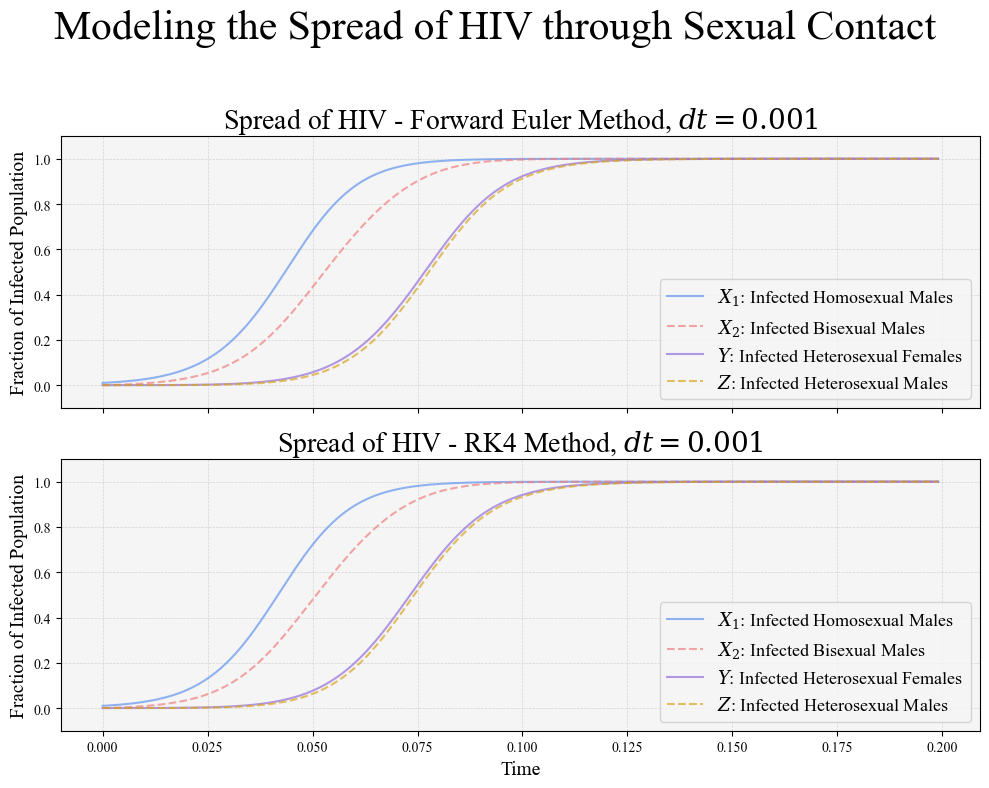

In [69]:
# Creating labels
rk4_label = r"Spread of HIV - RK4 Method, $dt=0.001$"
euler_label = r"Spread of HIV - Forward Euler Method, $dt=0.001$"
# Plotting
fig, ax = plt.subplots(2,1,figsize=(10, 8), sharex=True)
ax[0].plot(time, res_euler[:, 0]/p1, label='$X_1$: Infected Homosexual Males', alpha=0.7, color='cornflowerblue')
ax[0].plot(time, res_euler[:, 1]/p2, label='$X_2$: Infected Bisexual Males', alpha=0.7, color='lightcoral', ls='--')
ax[0].plot(time, res_euler[:, 2]/q, label='$Y$: Infected Heterosexual Females', alpha=0.7, color='mediumpurple')
ax[0].plot(time, res_euler[:, 3]/r, label='$Z$: Infected Heterosexual Males', alpha=0.7, color='goldenrod', ls='--')
ax[0].set_ylabel('Fraction of Infected Population', fontsize=14)
ax[0].set_title(euler_label, fontsize=20)
ax[0].legend(fontsize=13)
ax[0].set_ylim(-0.1, 1.1)

ax[1].plot(time, res_rk4[:, 0]/p1, label='$X_1$: Infected Homosexual Males', alpha=0.7, color='cornflowerblue')
ax[1].plot(time, res_rk4[:, 1]/p2, label='$X_2$: Infected Bisexual Males', alpha=0.7, color='lightcoral', ls='--')
ax[1].plot(time, res_rk4[:, 2]/q, label='$Y$: Infected Heterosexual Females', alpha=0.7, color='mediumpurple')
ax[1].plot(time, res_rk4[:, 3]/r, label='$Z$: Infected Heterosexual Males', alpha=0.7, color='goldenrod', ls='--')
ax[1].set_xlabel('Time', fontsize=14)
ax[1].set_ylabel('Fraction of Infected Population', fontsize=14)
ax[1].set_title(rk4_label, fontsize=20)
ax[1].legend(fontsize=13)
ax[1].set_ylim(-0.1, 1.1)

fig.suptitle('Modeling the Spread of HIV through Sexual Contact\n', fontsize=30)

plt.tight_layout()

In [70]:
# Residuals between the two methods
pop_array = np.array([p1, p2, q, r])
residuals = np.abs(res_euler - res_rk4)
max_residuals = np.max(residuals / pop_array, axis=0)
print(f"Maximum residuals between Euler and RK4 methods:\nX1: {max_residuals[0]:.3f}\nX2: {max_residuals[1]:.3f}\nY: {max_residuals[2]:.3f}\nZ: {max_residuals[3]:.3f}")

Maximum residuals between Euler and RK4 methods:
X1: 0.048
X2: 0.046
Y: 0.089
Z: 0.090


Above a simulation of the spread of HIV throgh sexual contact is seen. 

The simulation is done with coefficients $a_1 = 10, a_2 = b_1 = 5$ and $b_2 = b_3 = c_1 = c_2 = d_1 = 1$.

After $t\approx 0.125$ all populations are completely infected, but it is clear that some poplulations get there before others fx. Homosexuals and Bisexuals. This is due to the relationship between the parameters where $a_1 > a_2 = b_1 > ...$ Here $a_1$ and $a_2$ are the coefficients controlling the infection of Homosexual males. Deacreasing these slightly would make the trajectories look more alike and reach full infection at about the same time. 

The upper plot shows the simulation done with forward euler stepping and the lower shows the simulation done with fourth order Runge-Kutta stepping. The two plots doesn't look very different, but the maximum resiudals between the two models are $[0.048, 0.046, 0.089, 0.090]$ for $[x_1, x_2, y, z]$ respectively, which is not negligible.

Below a plot is shown of the residuals between the two methods for all populations as a function of time. 

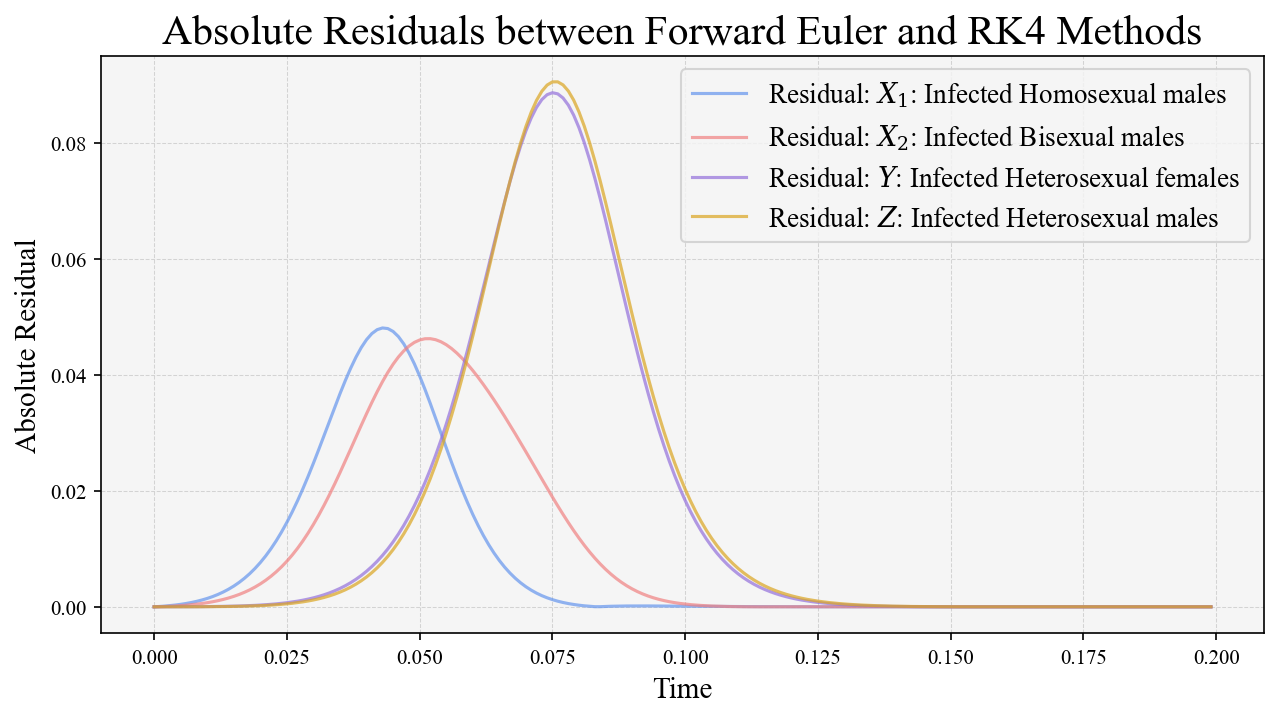

In [71]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
colors = ['cornflowerblue', 'lightcoral', 'mediumpurple', 'goldenrod']
infected_labels = ['$X_1$: Infected Homosexual males', '$X_2$: Infected Bisexual males', '$Y$: Infected Heterosexual females', '$Z$: Infected Heterosexual males']

for i, xn in enumerate(residuals.T):
    label = infected_labels[i]
    ax.plot(time, xn / pop_array[i], alpha=0.7, color=colors[i], label=f'Residual: {label}')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Absolute Residual', fontsize=14)
ax.set_title('Absolute Residuals between Forward Euler and RK4 Methods', fontsize=20)
ax.legend(fontsize=13)

plt.show()

In [72]:
# e parameter initialization
frac = (x1 + x2 + y + z) / (p1 + p2 + q + r)
base = np.linspace(0.001, 5, 5)
e_par = base * frac

# Death parameter initialization
death_par = "Off"
death_rates = [0.05] * 4

params = [p1, p2, q, r, a1, a2, b1, b2, b3, c1, c2, d1, e_par, death_par, death_rates]
state = (x1, x2, y, z)

change_rk4 = []
change_euler = []

for en in base:
    res_euler = run_euler(state, params.copy(), time, e_base=en)
    change_euler.append(res_euler)
    res_rk4 = run_rk4(state, params.copy(), time, e_base=en)
    change_rk4.append(res_rk4)



_____
## Including blood transfusion

Blood transfusion is added to the equations by adding the terms

$$
e(p_1 - x_1),\hspace{0.5cm} e(p_2 - x_2),\hspace{0.5cm} e(q - y),\hspace{0.5cm} e(r - z)
$$

for $\frac{dx_1}{dt}, \frac{dx_2}{dt}, \frac{dy}{dt}, \frac{dz}{dt}$ respectively. Each of these terms adds a possibility of infecting a new person in a population through blood tranfusion with a rate $e$. This parameter is defined in the following way:

$$
    e = e_i \frac{x_1 + x_2 + y + z}{p_1 + p_2 + r + q}, \hspace{1cm} e_i \in [0.001, 5]
$$

There are two things to note about the definition of the parameter. Firstly, $e_i$ can be changed for different simulations yielding differnt effects from blood transfusion. Secondly, the fraction grows as more people are infected making it more likely that people get infected from blood transfusion as more people get sick.

The results of the simulations using both RK4 and euler stepping are shown below.

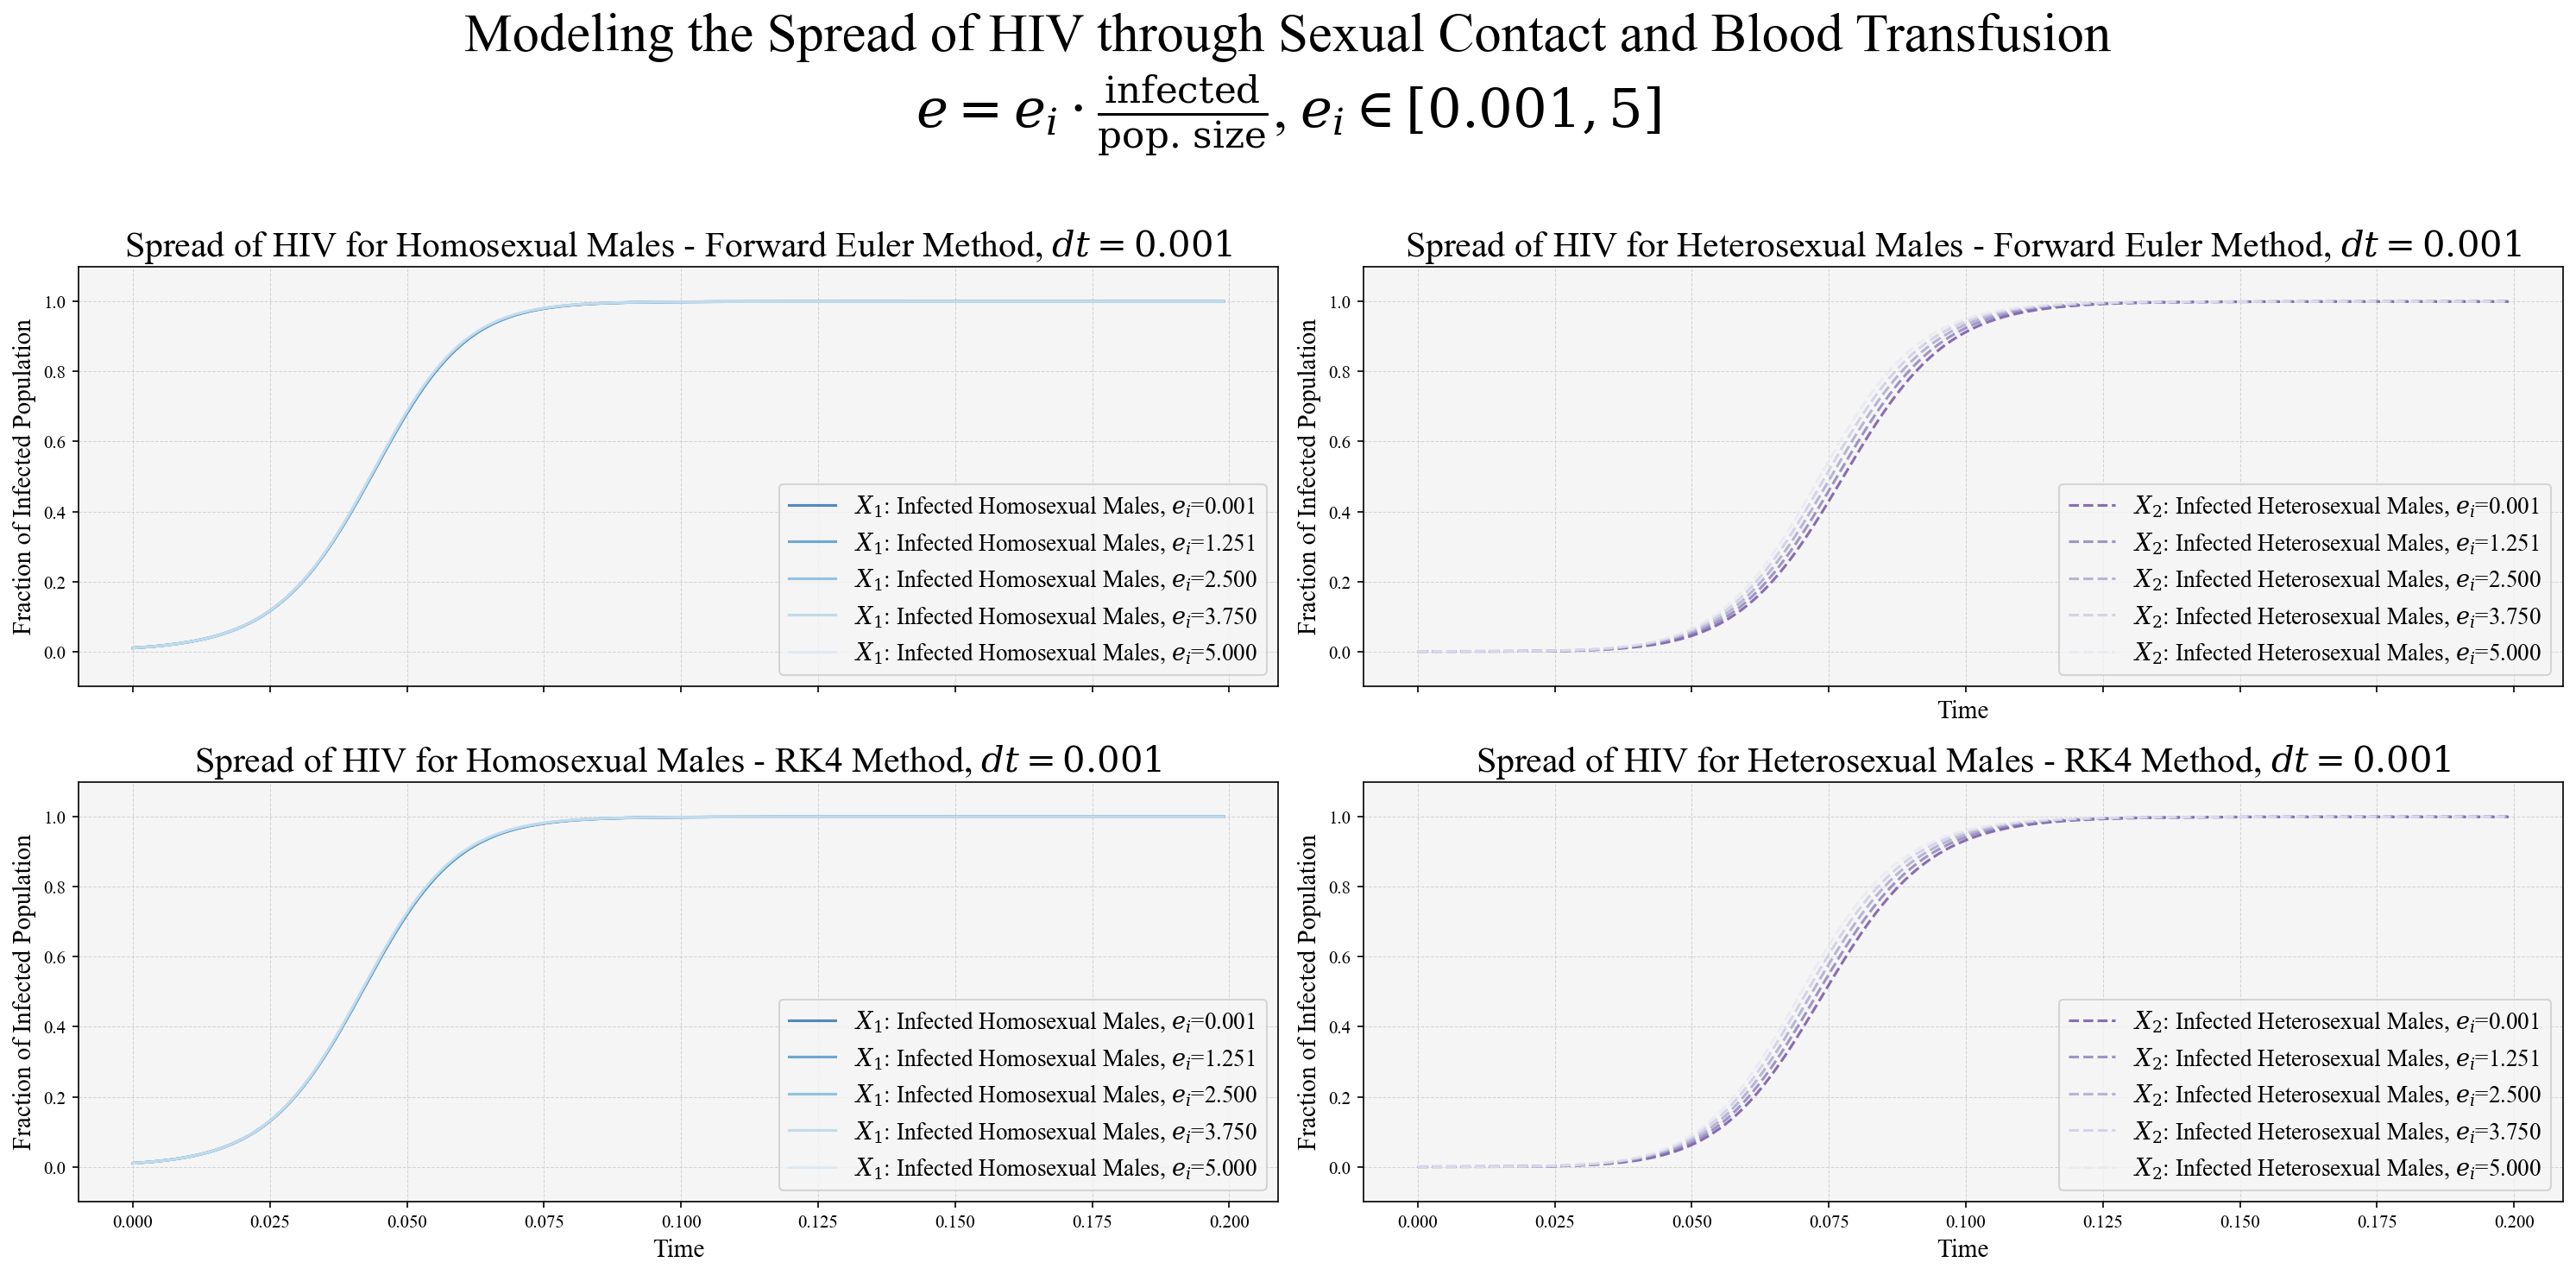

In [73]:
rk4_label = r"Spread of HIV for Heterosexual Males - RK4 Method, $dt=0.001$"
euler_label = r"Spread of HIV for Heterosexual Males - Forward Euler Method, $dt=0.001$"
blues = sns.color_palette("Blues", n_colors=len(base))[::-1]
greens = sns.color_palette("Purples", n_colors=len(base))[::-1]

fig, ax = plt.subplots(2,2,figsize=(20, 10), sharex=True, dpi=150)

for i, en in enumerate(base):
    res_euler = change_euler[i]
    ax[0,0].plot(time, res_euler[:, 0]/p1, label=f'$X_1$: Infected Homosexual Males, $e_i$={en:.3f}', alpha=0.7, color=blues[i])
    ax[0,0].set_ylabel('Fraction of Infected Population', fontsize=14)
    ax[0,0].set_title(r"Spread of HIV for Homosexual Males - Forward Euler Method, $dt=0.001$", fontsize=20)

    ax[0,1].plot(time, res_euler[:, 3]/r, label=f'$X_2$: Infected Heterosexual Males, $e_i$={en:.3f}', alpha=0.7, color=greens[i], ls='--')
    ax[0,1].set_xlabel('Time', fontsize=14)
    ax[0,1].set_ylabel('Fraction of Infected Population', fontsize=14)
    ax[0,1].set_title(euler_label, fontsize=20)



    res_rk4 = change_rk4[i]
    ax[1,0].plot(time, res_rk4[:, 0]/p1, label=f'$X_1$: Infected Homosexual Males, $e_i$={en:.3f}', alpha=0.7, color=blues[i])
    ax[1,0].set_xlabel('Time', fontsize=14)
    ax[1,0].set_ylabel('Fraction of Infected Population', fontsize=14)
    ax[1,0].set_title(r"Spread of HIV for Homosexual Males - RK4 Method, $dt=0.001$", fontsize=20)

    ax[1,1].plot(time, res_rk4[:, 3]/r, label=f'$X_2$: Infected Heterosexual Males, $e_i$={en:.3f}', alpha=0.7, color=greens[i], ls='--')
    ax[1,1].set_xlabel('Time', fontsize=14)
    ax[1,1].set_ylabel('Fraction of Infected Population', fontsize=14)
    ax[1,1].set_title(rk4_label, fontsize=20)


for axi in ax.flatten():
    axi.legend(fontsize=13, loc='lower right')
    axi.set_ylim(-0.1, 1.1)

fig.suptitle('Modeling the Spread of HIV through Sexual Contact and Blood Transfusion\n' + r"$e = e_i \cdot \frac{\text{infected}}{\text{pop. size}}$, $e_i \in [0.001, 5]$" + "\n", fontsize=30)
plt.tight_layout()


In the plots above the simulations including blood transfusion are shown. These were done with the same initial parameters as before ($a_n, b_n$ etc), but with a varying $e$ parameter: $e_i \in [0.001, 5]$

In the plots on the left hand side, the different simulations are very hard to tell apart, and this is due to the infection constants $a_1$ and $a_2$ dominating the equation for infection of homosexual Males. The effect of $e$ is simply not large enough. In the euqation for infection of heterosexual males $\frac{dz}{dt}$ where $d_1 = 1$ the effect of $e$ *is* large enough, and the effect is visible in the plots on the right hand side. For larger $e_i$ the infection rate increases wich makes sense considering that $e$ is sort of an added infection factor independent of sexual contact. 

Even though the effect of $e$ varies between populations, the end result is still the same: everyone gets infected, so the equilibrium seems to be where all populations are completely infected.

In [74]:
# e parameter initialization
frac = (x1 + x2 + y + z) / (p1 + p2 + q + r)
base = 0.001
e_par = base * frac

# Death parameter initialization
death_par = "On"
dbs = np.linspace(0.05, 10, 5)

change_rk4_dr = []
change_euler_dr = []
state = (x1, x2, y, z)

for db in dbs:
    death_rate = [db] * 4
    params = [p1, p2, q, r, a1, a2, b1, b2, b3, c1, c2, d1, e_par, death_par, death_rate]
    res_euler = run_euler(state, params.copy(), time, e_base=en)
    change_euler_dr.append(res_euler)
    res_rk4 = run_rk4(state, params.copy(), time, e_base=en)
    change_rk4_dr.append(res_rk4)



_____

## Inlcuding death of infected people

For the final part of the assignment we included the possibility of death in each infected group. This was done by adding a term $r_n x_n$ to each of the equations, where $r_n$ is the rate of death for infected population $n$ and $x_n$ is the infected population $n$. Through all simulations $r_1 = r_2 = r_3 = r_4$ but they are changed to see the effect of a varying death rate. Death rates are tested in the space $r_n \in [0.05, 10]$.

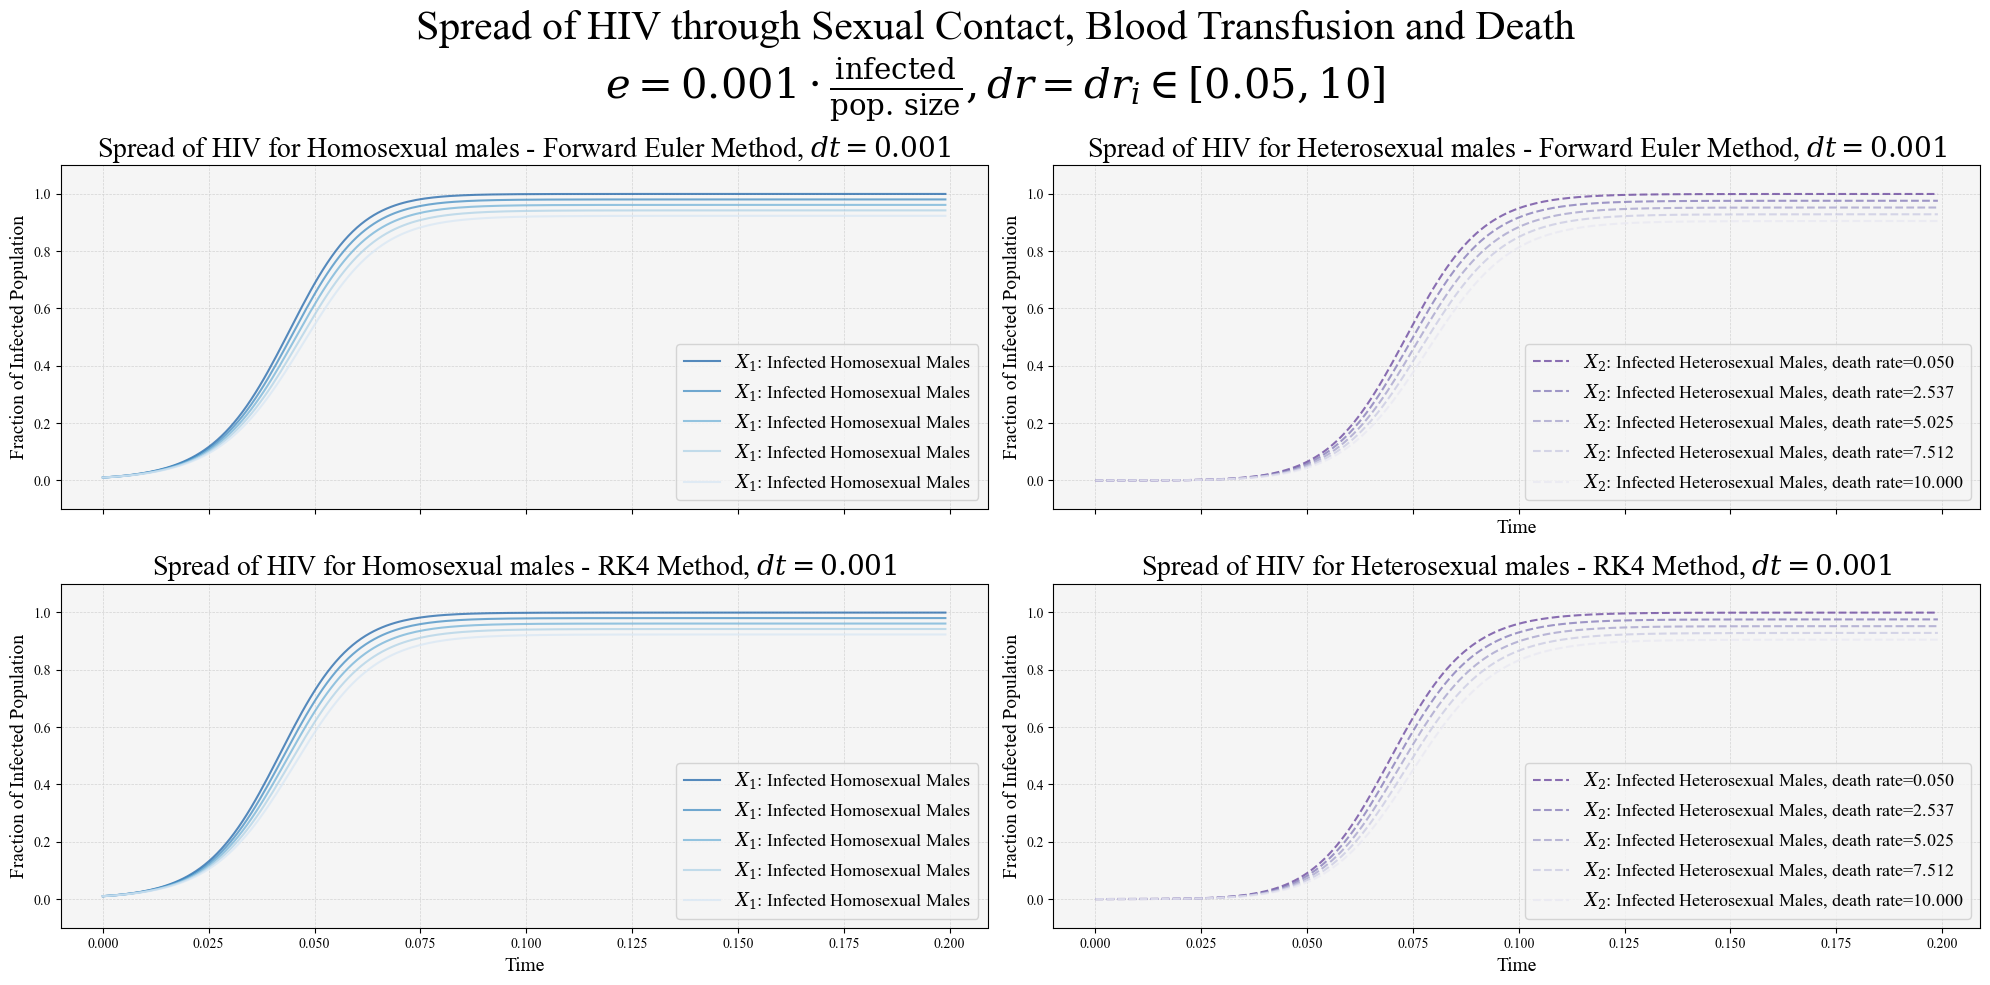

In [75]:

rk4_label = r"Spread of HIV for Homosexual males - RK4 Method, $dt=0.001$" 
euler_label = r"Spread of HIV for Homosexual males - Forward Euler Method, $dt=0.001$"

fig, ax = plt.subplots(2,2,figsize=(20, 10), sharex=True)
blues = sns.color_palette("Blues", n_colors=len(dbs))[::-1]
greens = sns.color_palette("Purples", n_colors=len(dbs))[::-1]

for i, db in enumerate(dbs):
    res_euler = change_euler_dr[i]
    ax[0,0].plot(time, res_euler[:, 0]/p1, label=f'$X_1$: Infected Homosexual Males', alpha=0.7, color=blues[i])
    ax[0,0].set_ylabel('Fraction of Infected Population', fontsize=14)
    ax[0,0].set_title(euler_label, fontsize=20)
    ax[0,0].legend(fontsize=13)
    ax[0,0].set_ylim(-0.1, 1.1)

    ax[0,1].plot(time, res_euler[:, 3]/r, label=f'$X_2$: Infected Heterosexual Males, death rate={db:.3f}', alpha=0.7, color=greens[i], ls='--')
    ax[0,1].set_xlabel('Time', fontsize=14)
    ax[0,1].set_ylabel('Fraction of Infected Population', fontsize=14)
    ax[0,1].set_title(r"Spread of HIV for Heterosexual males - Forward Euler Method, $dt=0.001$", fontsize=20)
    ax[0,1].legend(fontsize=13)
    ax[0,1].set_ylim(-0.1, 1.1)

    res_rk4 = change_rk4_dr[i]
    ax[1,0].plot(time, res_rk4[:, 0]/p1, label=f'$X_1$: Infected Homosexual Males', alpha=0.7, color=blues[i])
    ax[1,0].set_xlabel('Time', fontsize=14)
    ax[1,0].set_ylabel('Fraction of Infected Population', fontsize=14)
    ax[1,0].set_title(rk4_label, fontsize=20)
    ax[1,0].legend(fontsize=13)
    ax[1,0].set_ylim(-0.1, 1.1)

    ax[1,1].plot(time, res_rk4[:, 3]/r, label=f'$X_2$: Infected Heterosexual Males, death rate={db:.3f}', alpha=0.7, color=greens[i], ls='--')
    ax[1,1].set_xlabel('Time', fontsize=14)
    ax[1,1].set_ylabel('Fraction of Infected Population', fontsize=14)
    ax[1,1].set_title(r"Spread of HIV for Heterosexual males - RK4 Method, $dt=0.001$", fontsize=20)
    ax[1,1].legend(fontsize=13)
    ax[1,1].set_ylim(-0.1, 1.1)

fig.suptitle('Spread of HIV through Sexual Contact, Blood Transfusion and Death\n' + r"$e = 0.001 \cdot \frac{\text{infected}}{\text{pop. size}}, dr = dr_i \in [0.05, 10]$", fontsize=30)
plt.tight_layout()

Above a plot is shown of the spread of HIV for Heterosexual (Greens) and Homosexual (Blues) men. Both groups show the same tendency for increasing death rates: As the death rate increases, the virus spreads slower and slower. This intuitively makes sense as less sick people are alive to infect more people. Each simulation also reaches a different equilibrium depending on the death rate, where the ratio between sick people and healthy people decreases for increasing death rates. 

A weird but inherent effect of the model is that the the infected population doesn't diminish over time as would be expected in a real life scenario if the death ratio was high enough. This is due to the populations being kept constant: when a sick person dies, the total population number remains constant (p1 is still 5 for example) so it is kind of like adding a new healthy person. This is why the fraction of infected people never diminishes but instead reaches an equilibrium. The death rate and birth rate (of healthy people) are exatly the same so to speak.